In [2]:
# load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r1d1 = pd.read_csv("island-data-bottle-round-1/prices_round_1_day_-1.csv",sep = ';',index_col=0)
r1d0 = pd.read_csv("island-data-bottle-round-1/prices_round_1_day_0.csv",sep = ';' ,index_col=0)
r1d2 = pd.read_csv("island-data-bottle-round-1/prices_round_1_day_-2.csv",sep = ';' ,index_col=0)

In [4]:
def plot_orderbook_dist(df,ticker = 'BANANAS'):
    df[df['product']==ticker]['bid_volume_1'].hist(bins=100)
    df[df['product']==ticker]['ask_volume_1'].hist(bins=100)
    plt.title(ticker+' orderbook best bid and ask volume distribution')
    plt.legend(['bid_volume_1','ask_volume_1'])
    plt.show()
    plt.plot(df[df['product']==ticker]['bid_volume_1'],df[df['product']==ticker]['ask_volume_1'],'.')
    plt.title(ticker+' orderbook best bid and ask volume scatter')
    plt.xlabel('bid_volume_1')
    plt.ylabel('ask_volume_1')
    plt.show()

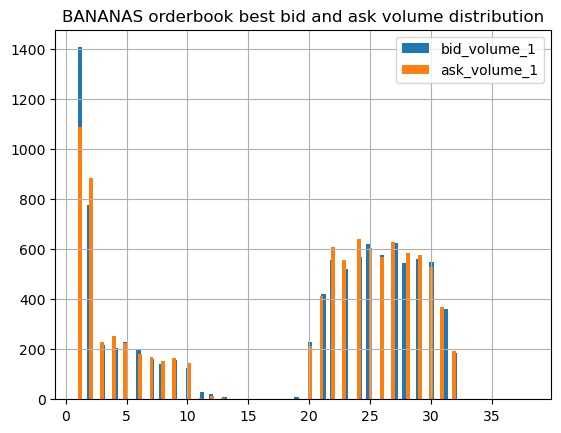

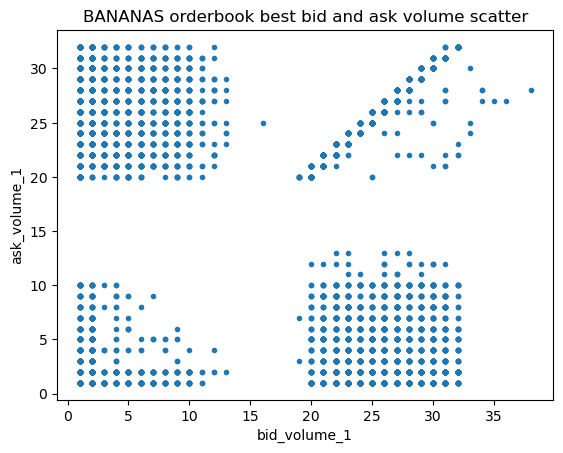

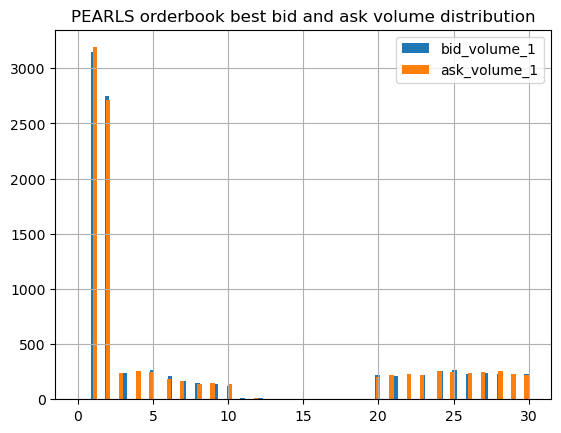

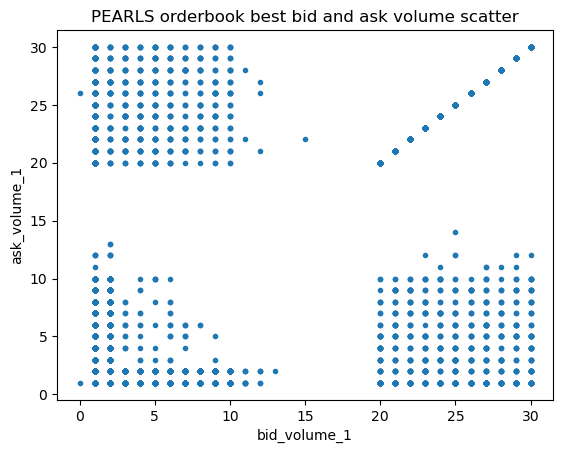

In [5]:
plot_orderbook_dist(r1d0,ticker = 'BANANAS')
plot_orderbook_dist(r1d0,ticker = 'PEARLS')

In [6]:
def calculate_expected_move(df):
    df['volume_imbalance'] = (df['bid_volume_1'] - df['ask_volume_1'])/(df['bid_volume_1'] + df['ask_volume_1'])
    df['expected_move'] = np.arctan(df['volume_imbalance'])*4/np.pi
    return df.copy()

In [7]:
def cal_orderbook_imbalance_status(df):
    # set the column 'imbalance_status' into 0,1,2,3 based on whether bid_volume_1 and ask_volume_1 are both greater than 15, only bid_volume_1 is greater than 15, only ask_volume_1 is greater than 15, or both are less than 15
    df['imbalance_status'] = 0
    df.loc[(df['bid_volume_1']>15) & (df['ask_volume_1']>15),'imbalance_status'] = 0
    df.loc[(df['bid_volume_1']>15) & (df['ask_volume_1']<=15),'imbalance_status'] = 1
    df.loc[(df['bid_volume_1']<=15) & (df['ask_volume_1']>15),'imbalance_status'] = 2
    df.loc[(df['bid_volume_1']<=15) & (df['ask_volume_1']<=15),'imbalance_status'] = 3
    return df.copy()

In [8]:
def calculate_future_mid_price_movement(df, window_size = 9):
    for ticker in df['product'].unique():
        for i in range(window_size+1):
            df.loc[df['product'] == ticker, 'future_mid_price_move_'+str(i)] = df[df['product'] == ticker]['mid_price'].diff(i).shift(-i)

    return df.copy()

In [9]:
r1d0_w_move = r1d0.pipe(calculate_expected_move).pipe(calculate_future_mid_price_movement).pipe(cal_orderbook_imbalance_status)

In [10]:
def plot_em_am(df,ticker):
    temp = df[df['product'] == ticker]
    fig, axs = plt.subplots(3, 3, figsize=(20, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(9):
        axs[i].plot(temp['expected_move'],temp['future_mid_price_move_'+str(i+1)],'o')
        axs[i].set_title("Correlation between future_mid_price_move_"+str(i+1)+"\n and signal: %.2f"%temp['future_mid_price_move_'+str(i+1)].corr(temp['expected_move']))
        axs[i].set_xlabel('signal')
        axs[i].set_ylabel('future_mid_price_move_step_'+str(i+1))
    plt.show()
    return 0


In [11]:
def print_status_count(df):
    # print the percentage and count of each imbalance status for each ticker
    for ticker in df['product'].unique():
        temp = df[df['product'] == ticker]
        print(ticker)
        print(temp['imbalance_status'].value_counts(normalize=True))
        print(temp['imbalance_status'].value_counts())
        print('')

In [12]:
r1d0_w_move.pipe(print_status_count)

PEARLS
3    0.6644
0    0.1737
2    0.0816
1    0.0803
Name: imbalance_status, dtype: float64
3    6644
0    1737
2     816
1     803
Name: imbalance_status, dtype: int64

BANANAS
0    0.3597
2    0.2892
1    0.2741
3    0.0770
Name: imbalance_status, dtype: float64
0    3597
2    2892
1    2741
3     770
Name: imbalance_status, dtype: int64



In [13]:
r1d0_w_move[r1d0_w_move['product']=='BANANAS'].groupby('imbalance_status')['future_mid_price_move_1'].mean()

imbalance_status
0    0.021268
1    1.065146
2   -1.024723
3   -0.070779
Name: future_mid_price_move_1, dtype: float64

In [14]:
r1d0_w_move[r1d0_w_move['product']=='PEARLS'].groupby('imbalance_status')['future_mid_price_move_1'].mean()

imbalance_status
0    0.032815
1    2.214197
2   -2.281250
3    0.003763
Name: future_mid_price_move_1, dtype: float64

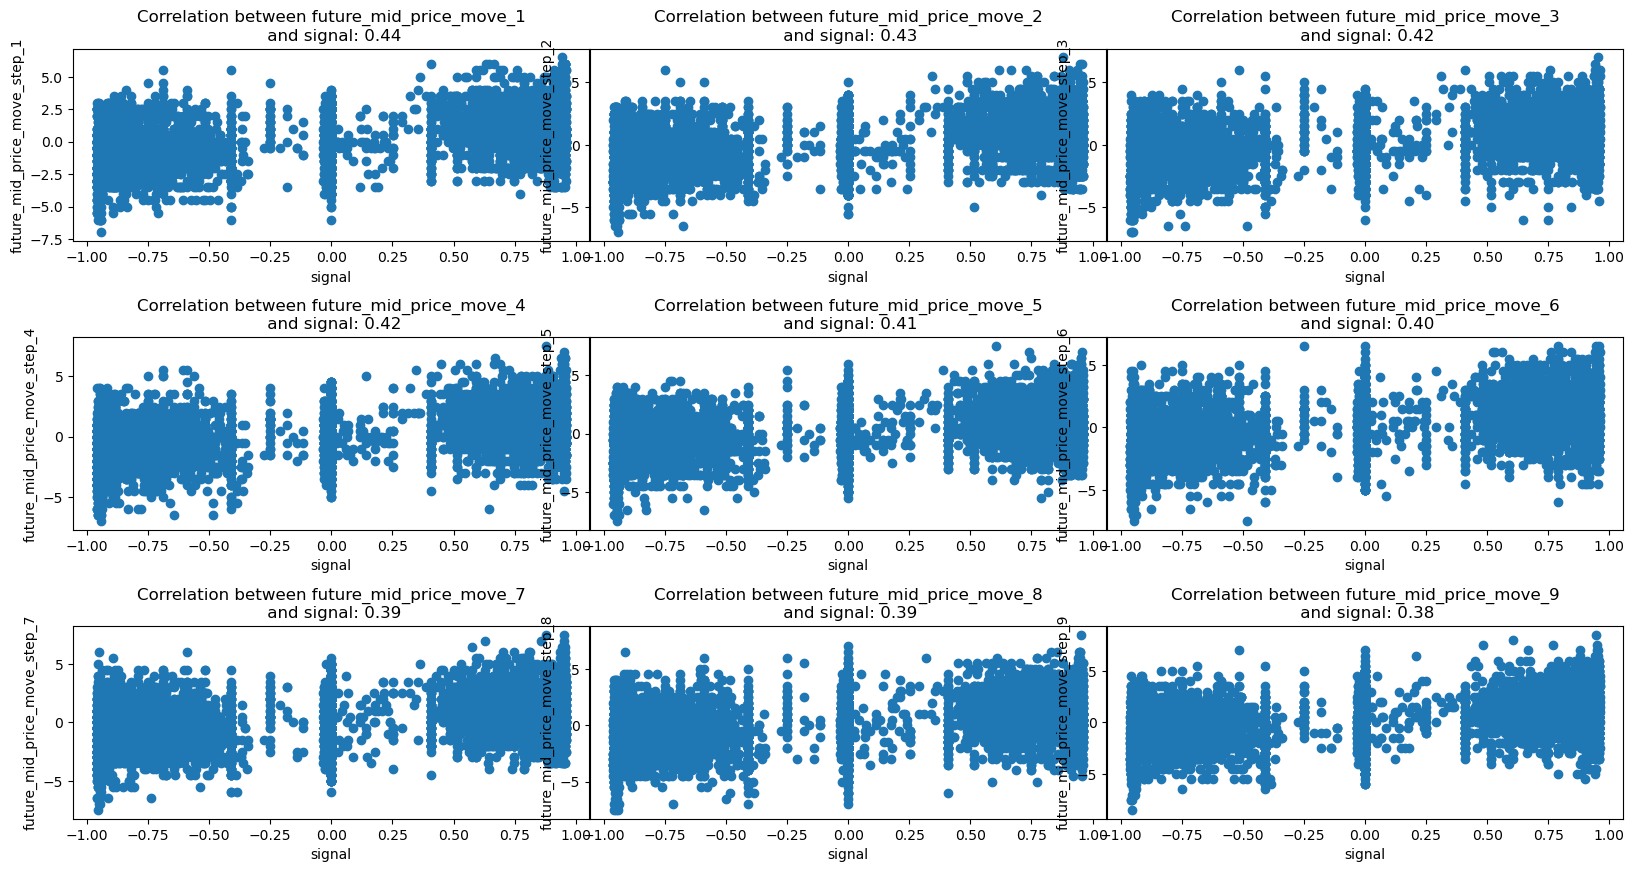

0

In [15]:
r1d0_w_move.pipe(plot_em_am,ticker = 'BANANAS')

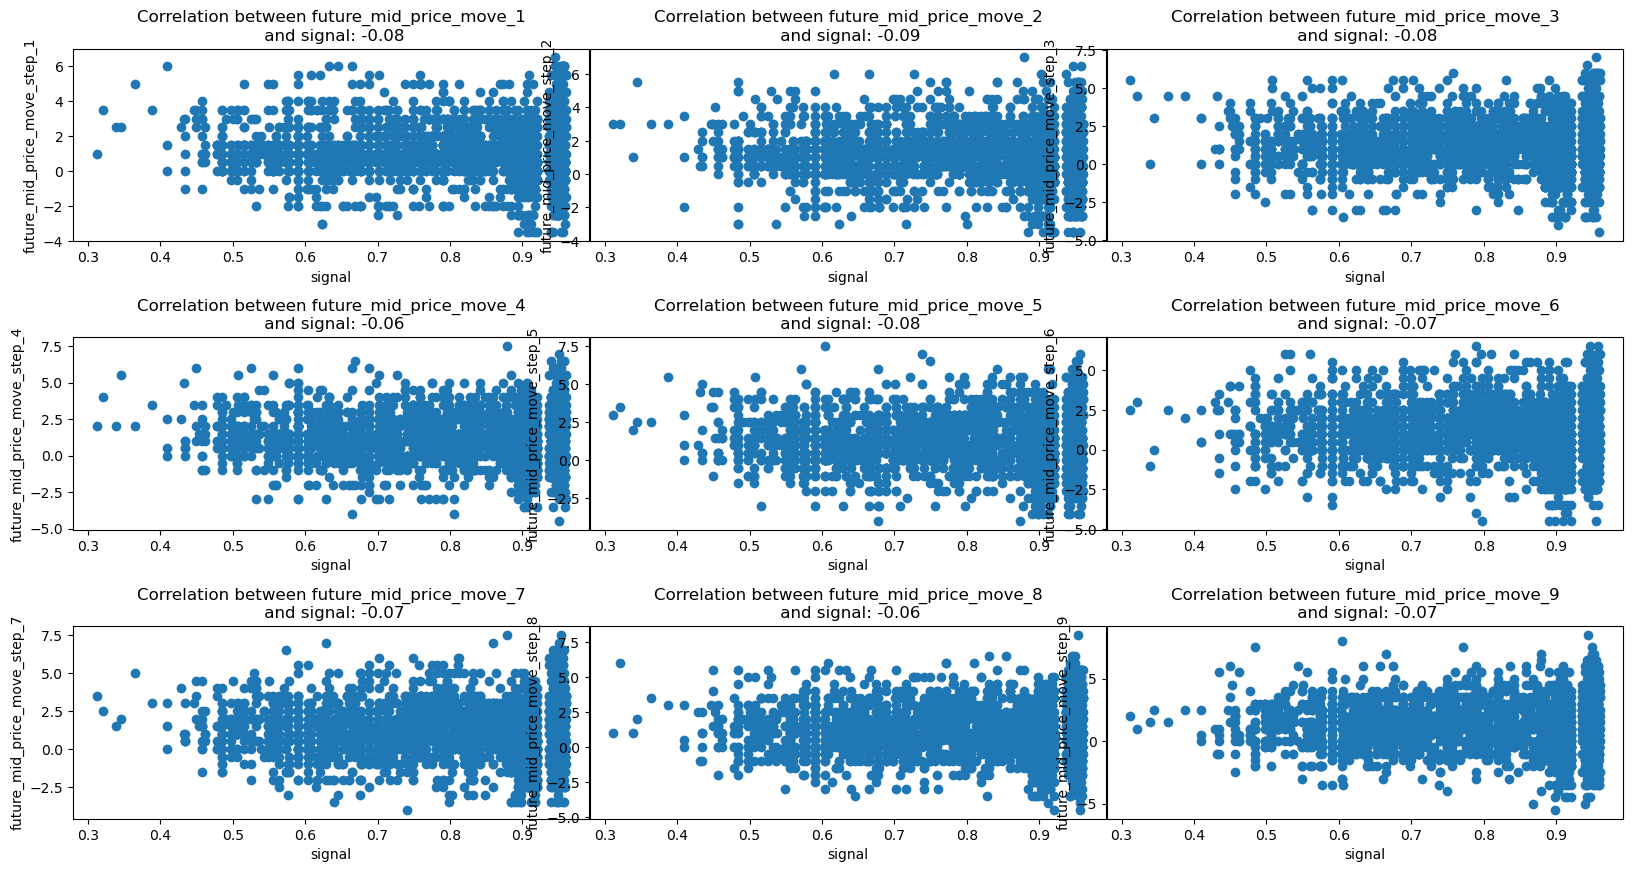

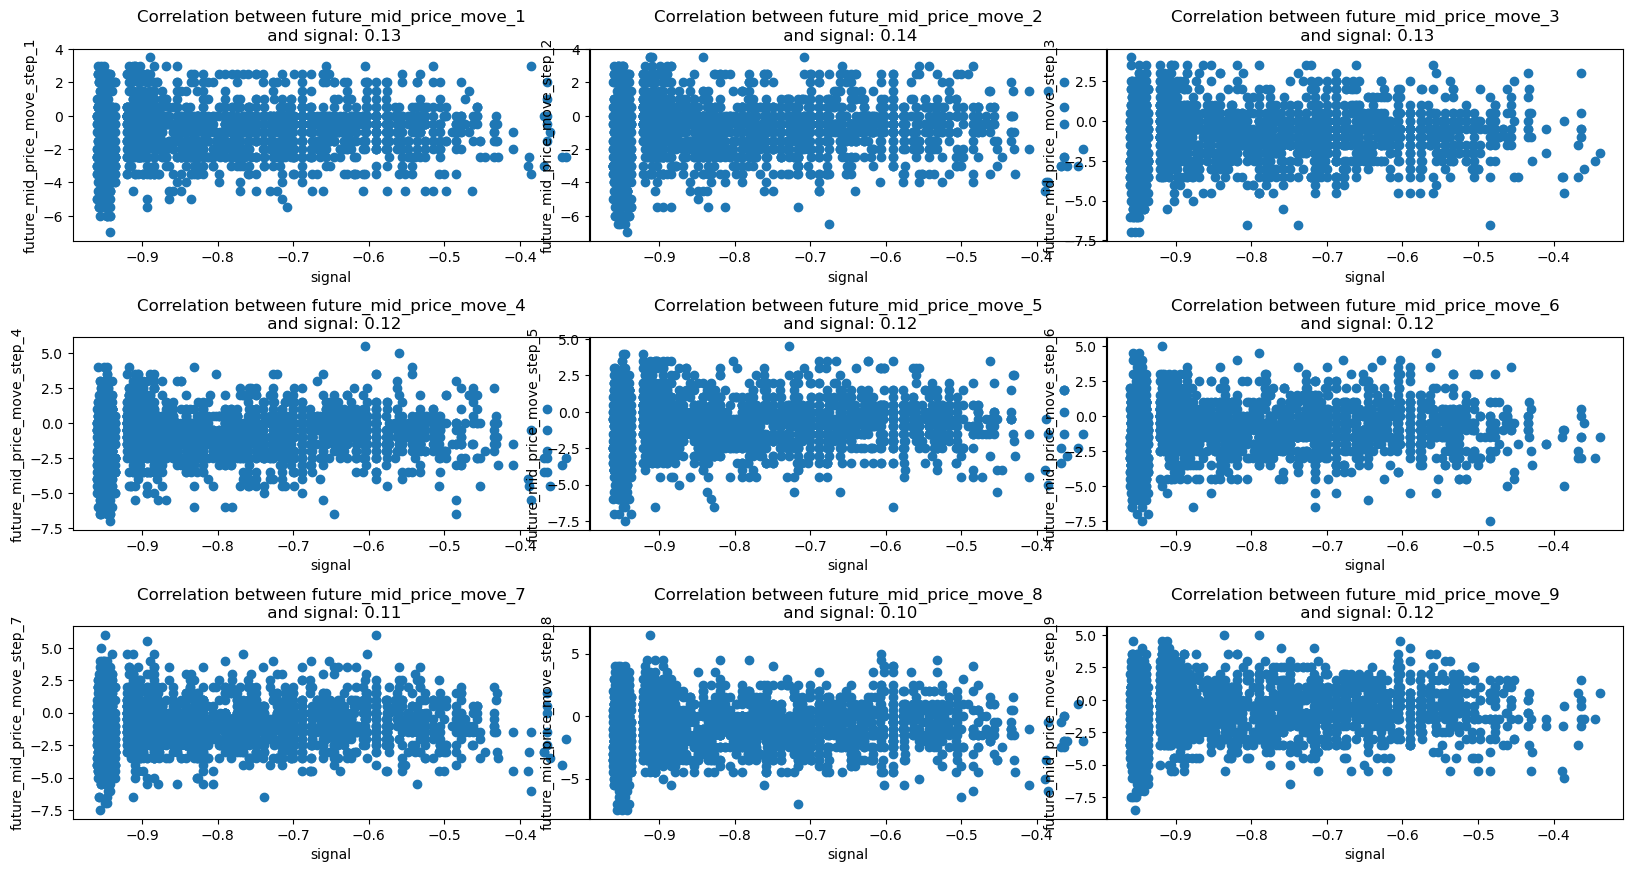

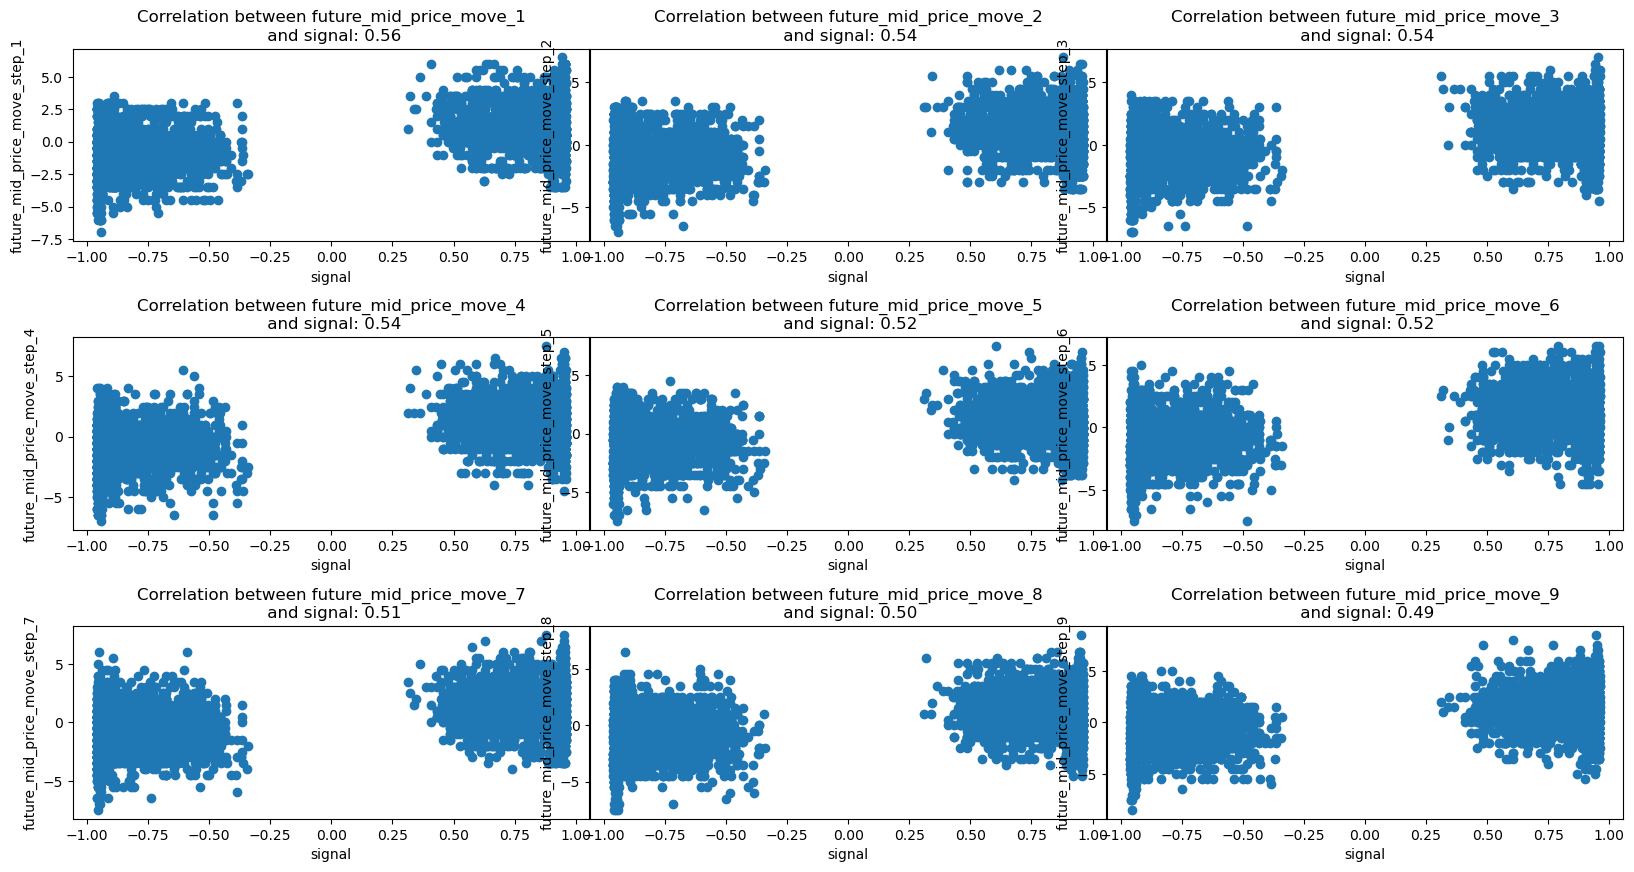

0

In [16]:
# what if we only look at the imbalance status that is not 0 or 3, i.e. the volume differen is large enough
r1d0_w_move[(r1d0_w_move['imbalance_status']==1)].pipe(plot_em_am,ticker = 'BANANAS')
r1d0_w_move[(r1d0_w_move['imbalance_status']==2)].pipe(plot_em_am,ticker = 'BANANAS')
r1d0_w_move[(r1d0_w_move['imbalance_status']!=0)&(r1d0_w_move['imbalance_status']!=3)].pipe(plot_em_am,ticker = 'BANANAS')

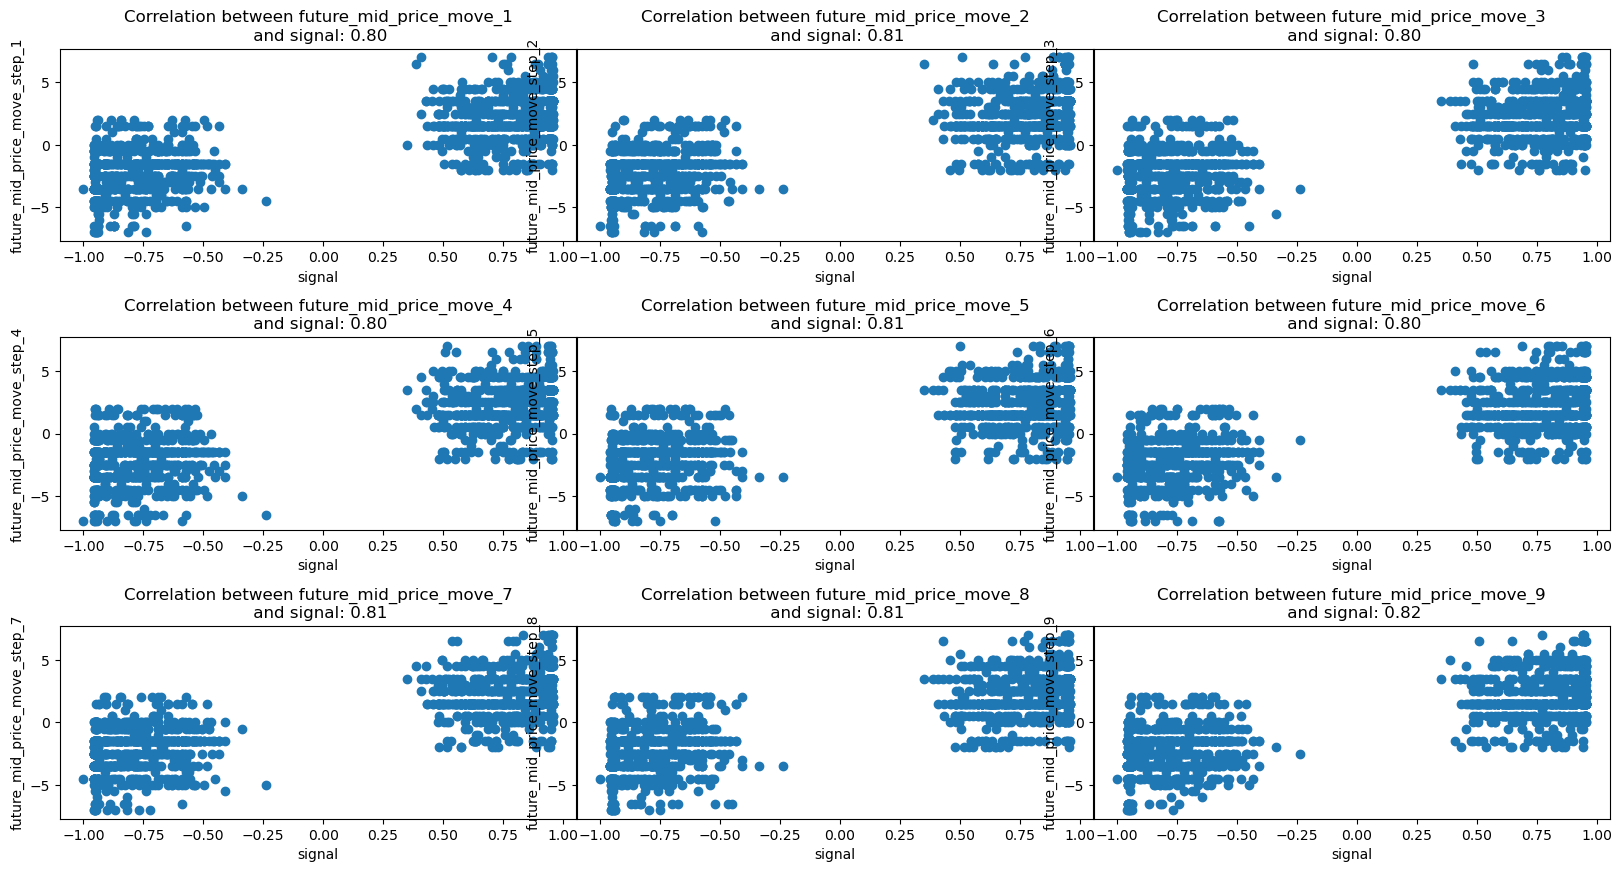

0

In [17]:
r1d0_w_move[(r1d0_w_move['imbalance_status']!=0)&(r1d0_w_move['imbalance_status']!=3)].pipe(plot_em_am,ticker = 'PEARLS')

In [18]:
r1d1_w_move = r1d1.pipe(calculate_expected_move).pipe(calculate_future_mid_price_movement).pipe(cal_orderbook_imbalance_status)
r1d2_w_move = r1d2.pipe(calculate_expected_move).pipe(calculate_future_mid_price_movement).pipe(cal_orderbook_imbalance_status)

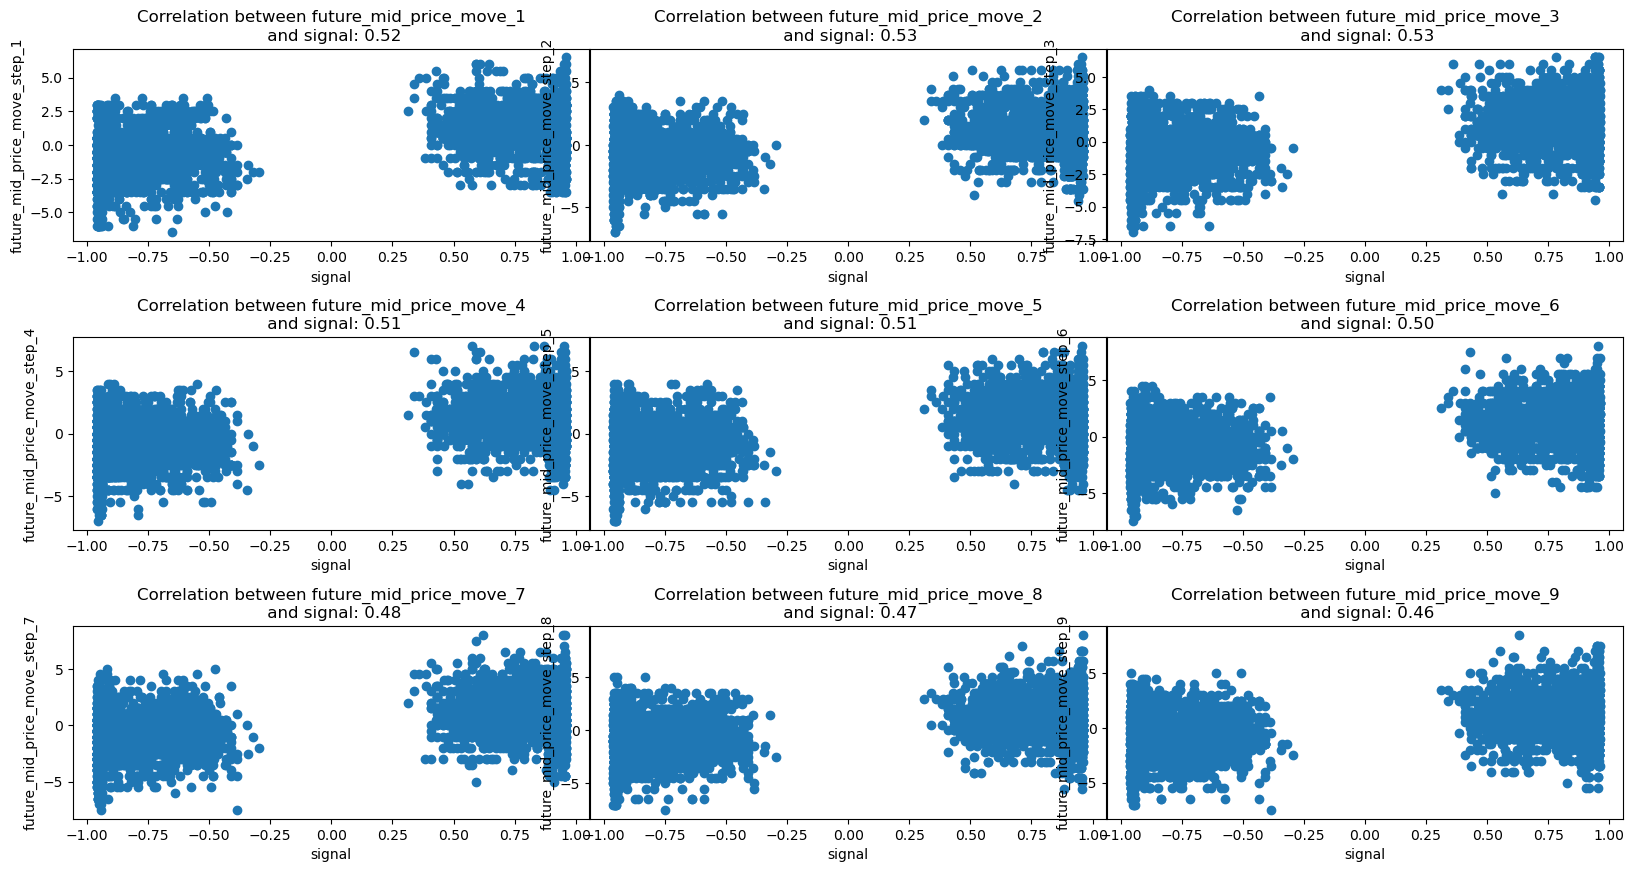

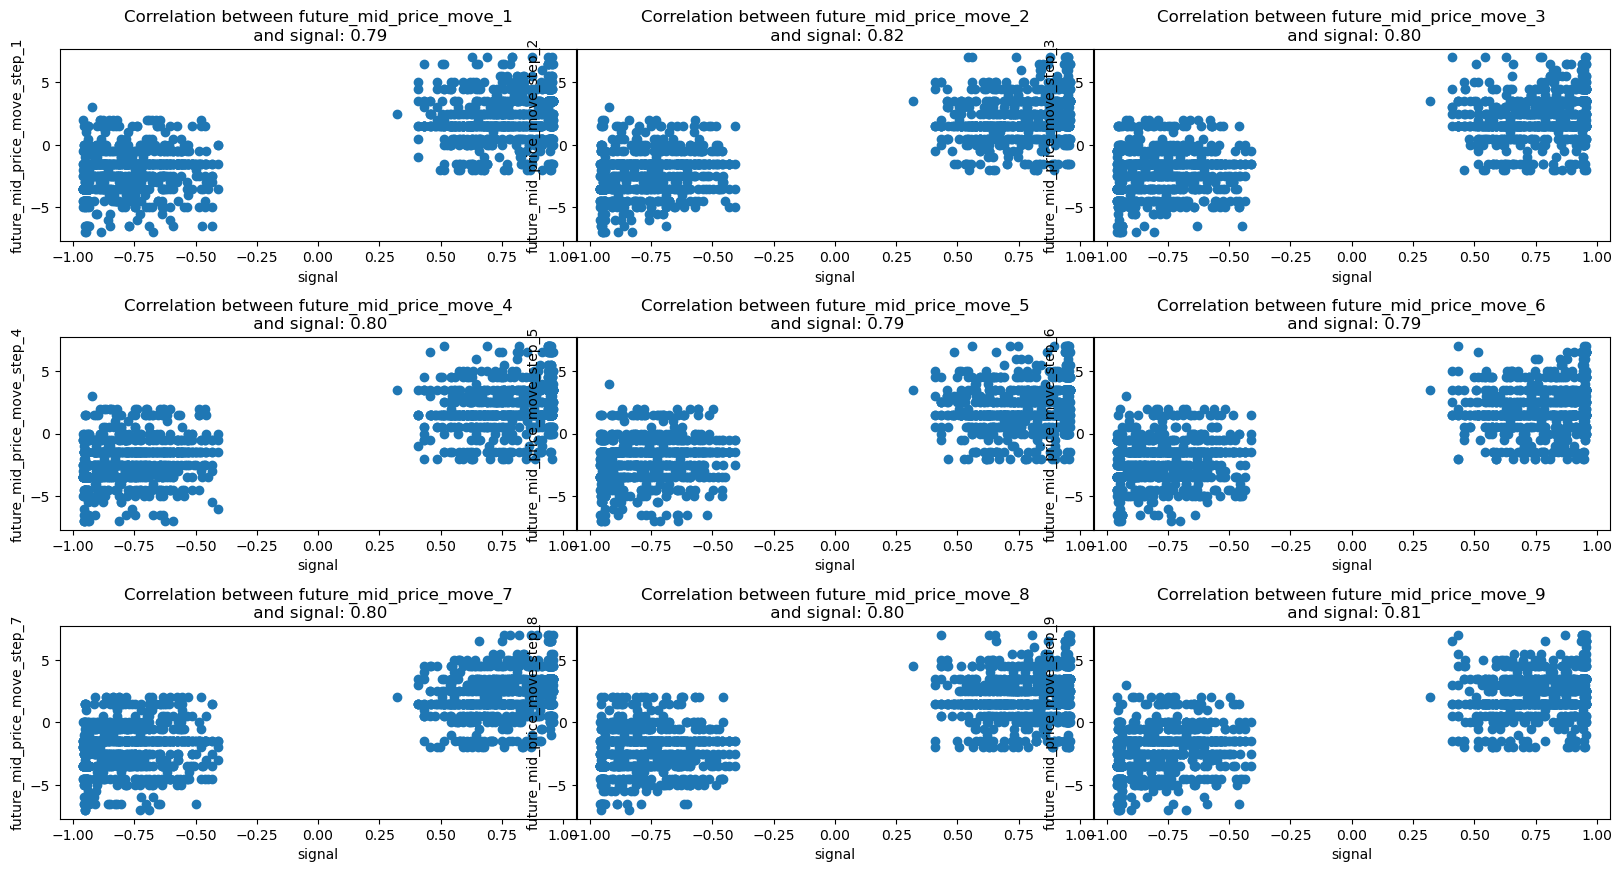

0

In [19]:
r1d1_w_move[(r1d1_w_move['imbalance_status']!=0)&(r1d1_w_move['imbalance_status']!=3)].pipe(plot_em_am,ticker = 'BANANAS')
r1d1_w_move[(r1d1_w_move['imbalance_status']!=0)&(r1d1_w_move['imbalance_status']!=3)].pipe(plot_em_am,ticker = 'PEARLS')

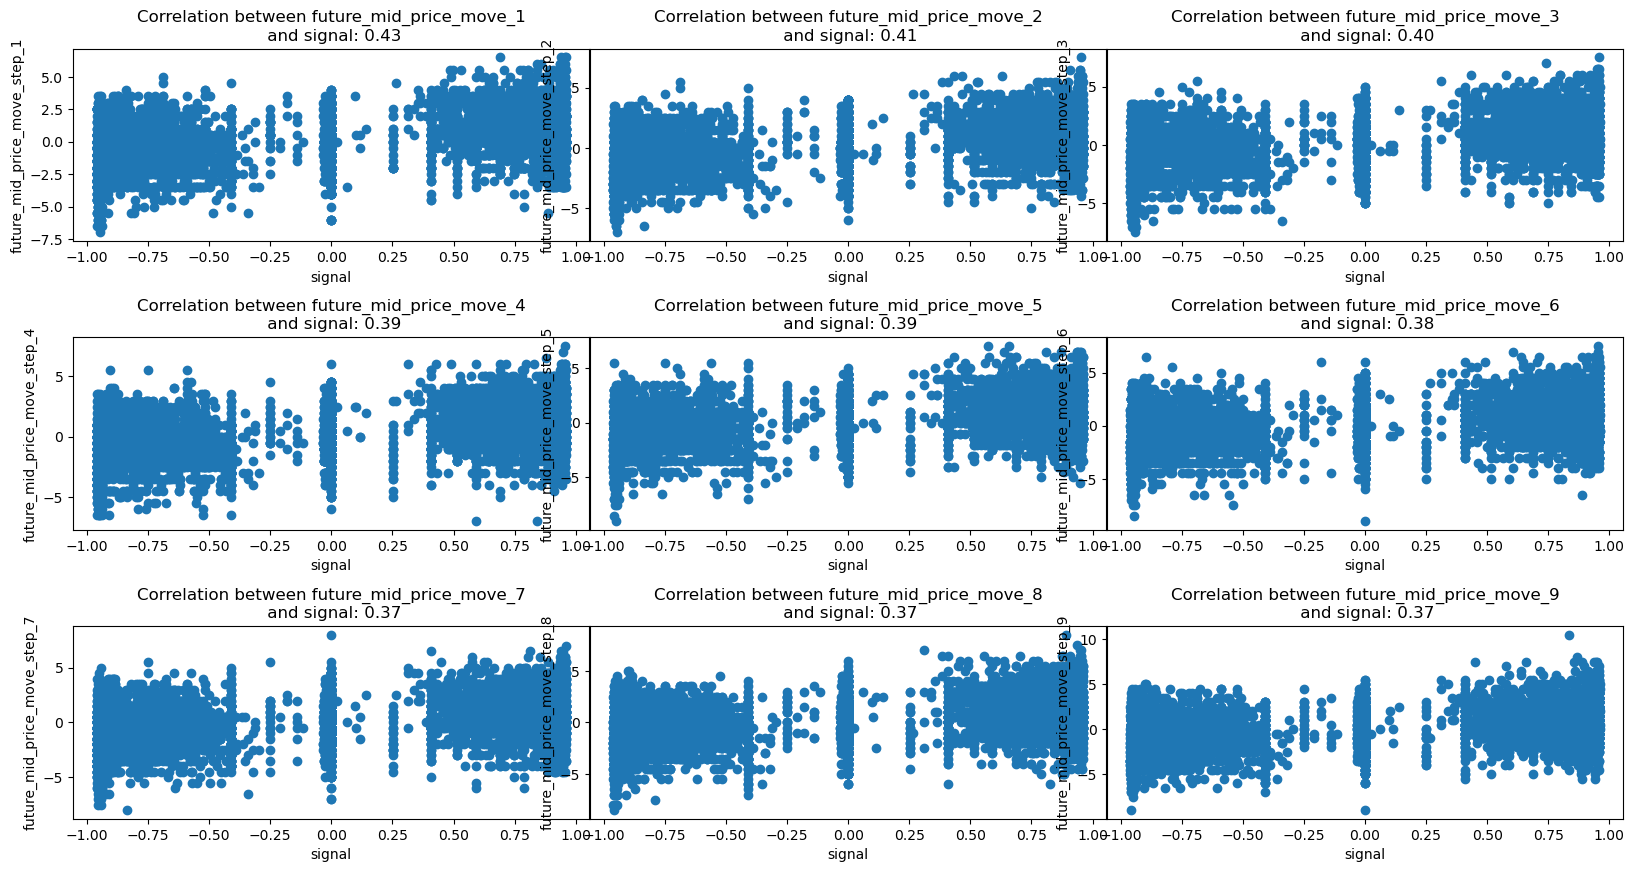

0

In [20]:
r1d2_w_move.pipe(plot_em_am,ticker = 'BANANAS')


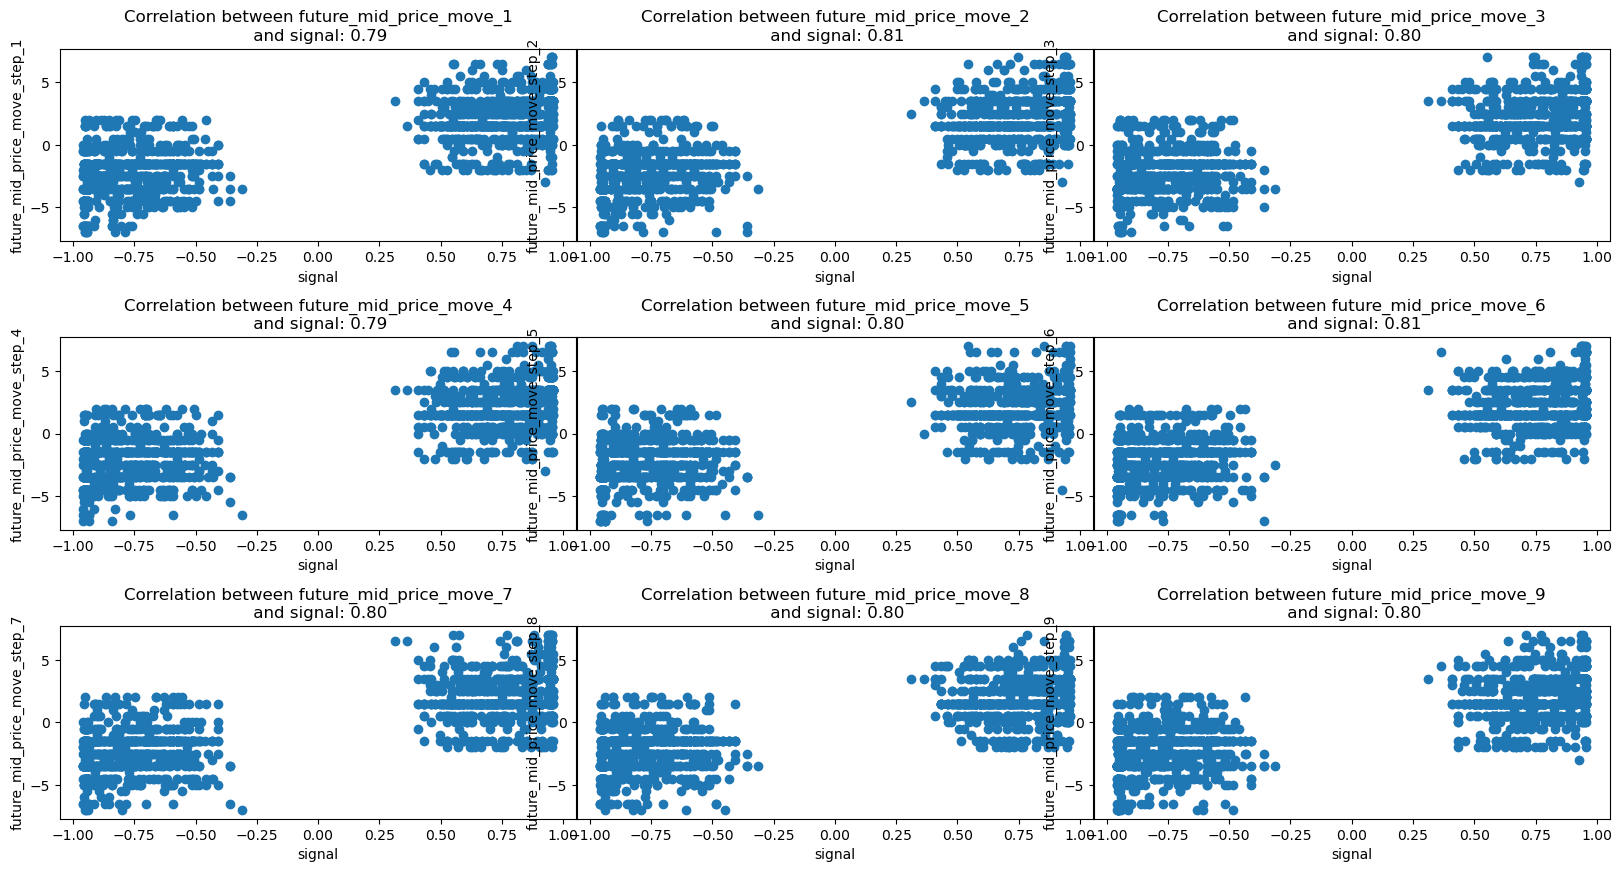

0

In [21]:
r1d2_w_move[(r1d2_w_move['imbalance_status']!=0)&(r1d2_w_move['imbalance_status']!=3)].pipe(plot_em_am,ticker = 'PEARLS')

In [22]:
r1d1_w_move[r1d1_w_move['product']=='PEARLS'].groupby('imbalance_status')['future_mid_price_move_1'].mean()

imbalance_status
0    0.085202
1    2.252433
2   -2.168525
3   -0.038946
Name: future_mid_price_move_1, dtype: float64

In [23]:
r1d1_w_move[r1d1_w_move['product']=='BANANAS'].groupby('imbalance_status')['future_mid_price_move_1'].mean()

imbalance_status
0    0.002534
1    1.019462
2   -0.940525
3   -0.142016
Name: future_mid_price_move_1, dtype: float64

In [24]:
r1d2_w_move[r1d2_w_move['product']=='PEARLS'].groupby('imbalance_status')['future_mid_price_move_1'].mean()
r1d2_w_move[r1d2_w_move['product']=='BANANAS'].groupby('imbalance_status')['future_mid_price_move_1'].mean()

imbalance_status
0   -0.040758
1    1.097701
2   -0.971585
3   -0.157407
Name: future_mid_price_move_1, dtype: float64